# EMC Final Project

In [1]:
from brian2 import *

%matplotlib inline

First let's describe the dynamics of the saturating synapse model (since it's simpler):

$$
\begin{eqnarray}
s_n(t)       &=& \sum_{t_n} \delta ( t - t_n) \\
\dot{r_n}(t) &=& -\lambda_s r_n(t) + s_n(t) \\
\dot{V_n}(t) &=& -\lambda_V V_n(t) + \sum_{m=1}^T A_{nm} \tanh{(\gamma r_m(t))} + V_r \lambda_s r_n(t) - \theta s_n(t) + I_{e,n}(t) \\
\end{eqnarray}
$$

Next, let's describe each of the various parameters and variables necessary to implement the model:

* Incoming spiketrain, $s(t)$
    * Just a train of delta impulses - no parameters needed.
    * Simply increment on-spike with Brian2
* Normalized synaptic current, $r(t)$
    * $\lambda_s = \tau_s^{-1}$ : time constant of synaptic decay (consistent for all synapses in this model)
* Membrane potential, $V(t)$
    * $\lambda_V = \tau_m^{-1}$ : membrane time constant for neuron
    * $A_{nm}$  : maximum synapse strength from neuron `m` to neuron `n`
    * $\gamma$  : "fraction of synaptic resources consumed" by the synapse
    * $V_r$     : resting voltage (temporally integrated size of afterdepolarization recovery current)
    * $\theta$  : threshold voltage (compared to reset voltage)
    * $I_{e,n}$ : external input current
    
Now, let's set some of those parameters as defined in the paper and supplemental materials.

In [2]:
lambda_s = 1/(100 * ms)
lambda_v = 1/(1 * second)

theta = 0.05
gamma = 0.05
V_r = 0.9 * theta

In [3]:
N = 50  # number of neurons
g = 0.5 # defines weight distribution for resevoir weights
p = 0.1 # probability of synapse within resevoir

Now, we'll define the differential equations for Brian2 to implement in the model.

In [4]:
eqsNeuSat = '''
dV/dt = -lambda_v * V + Hz*satsyn + V_r * lambda_s * r  + Hz*(Iext + Ifb) : 1
satsyn : 1 # saturation synapse summation term
Iext : 1 # input current
Ifb : 1 # feedback current

dr/dt = -lambda_s * r : 1
'''

#resetSat = 'V -= theta' # is technically what's in the paper, but doesn't seem to work
resetSat = 'V = 0'
threshSat = 'V > theta'
eqsSynSat = '''
A : 1 # maximum synaptic weight
wf : 1 # feedback weights
satsyn_post = A * tanh(gamma * r_pre) : 1 (summed)
plastic : boolean (shared)
'''
eqsPreSat = 'r += 1'

In [5]:
start_scope()

resevoir = NeuronGroup(N, eqsNeuSat, threshold=threshSat, reset=resetSat, method='euler')
resevoir.V = V_r

satSyn = Synapses(resevoir, resevoir, eqsSynSat, on_pre=eqsPreSat)
satSyn.connect(p=p) # connect with probability p
satSyn.A = g**2/(N*p) * randn(satSyn.N[:]) # set resevoir synapse weights

Let's view the synaptic connections within the resevoir to make sure we've implemented them correctly; they should be randomly dispersed, with random weights (represented via dot size, scaled to be easily distinguished).

WARNING    /opt/conda/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
 [py.warnings]


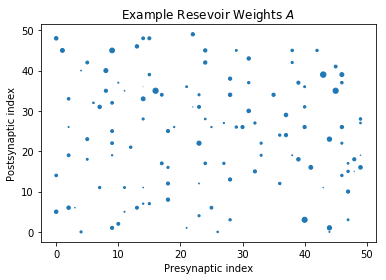

In [6]:
scatter(satSyn.i,satSyn.j,s=satSyn.A*200)
xlabel('Presynaptic index')
ylabel('Postsynaptic index')
title('Example Resevoir Weights $A$')
show()

Now, let's define the output summation to find $z = w^o\tilde{r}$. Equation 13 defines this output as $$z_k(t) = \sum_{m=1}^N w_{km}^o \tanh{(\gamma r_m(t))}$$ where $k$ represents the dimensionality of the output (here we'll assume 1-dimensional) and $w_{km}^o$ the learnable synaptic output weights. In Brian, there are a few ways that we could implement this, but to best separate out training/testing and keep things as changeable as possible, we'll implement the output as a pseudo-neuron (i.e. a non-spiking neuron that simply sums the weights).

I'll consider the situation where there is external feedback (cf. Fig 2b), because it's more accurate/robust than the no-feedback case but simpler (and mathematically equivalent to) the intra-resevoir-recurrent-feedback case.

----

Output weights are updated via Recursive Least Squares (RLS) and FORCE algorithms; see [Sussillo and Abbott, 2009](https://doi.org/10.1016/j.neuron.2009.07.018) and [2012](https://doi.org/10.1371/journal.pone.0037372) for development and explanation. Simply, we update a running filter estimate of the inverse correlation matrix $P$ by the update scheme $$P(t) = P(t - \Delta t) - \frac{P(t - \Delta t) \tilde{r}(t) \tilde{r}(t)' P(t - \Delta t)'}{1 + \tilde{r}(t)' P(t - \Delta t) \tilde{r}(t)}$$ or, more simply, $$P(t) = P(t - \Delta t) - \frac{k k'}{1 + \tilde{r}(t)' k}$$ where $k = P(t - \Delta t) \tilde{r}(t)$ and $\tilde{r}(t) =  \tanh{(\gamma r(t))}$.

This running filter estimate is used to update the output weights based on the current training error $e(t) = z(t) - F(t)$ (recall that we assume $k=1$). Here, the output signal $z(t)$ should track the target signal $F(t)$ as closely as possible. The output weights $w_m^o$ are then updated with the equation,
$$w_{\beta}^o(t) = w_{\beta}^o(t - \Delta t) - e(t) \sum_{\rho} P_{\beta \rho}(t)\tilde{r}_{\rho}(t)$$
where indices $\beta$ and $\rho$ are the range of all synapses ($\beta, \rho = 1,...,N$).

-----

To make this all happen, we'll make an input "neuron" that inputs a function to the resevoir and an output "neuron" that computes the weighted sum $z$ described above.

In [7]:
# This is a place where things get weird - I'm not sure whether it should be updated on a custom event that triggers
# at every time step, or on the pre-set "pre" event with a "(summed)" tag
inModel = '''
F = int(training)*drivingFunc + (1-int(training))*noiseInp : 1
drivingFunc = cos(28 * pi * Hz * t) - 1.5 * sin(14 * pi * Hz * t) : 1
dnoiseInp/dt = noiseAmp * xi * 1/sqrt(second) : 1

training : boolean (shared)
noiseAmp : 1
'''

inneur = NeuronGroup(1,model=inModel)#,events={'custom_event': 't>0*second'})
inneur.noiseAmp = 0.01
insyn = Synapses(inneur, resevoir,
                model='''wi:1 # fixed input weights
                         Iext_post = wi * F_pre : 1 (summed)
                         ''')

#insyn = Synapses(inneur, resevoir,model='wi:1',on_pre='Iext += wi*F_pre',on_event={'pre': 'custom_event'})
insyn.connect()

insyn.wi = '2*rand() - 1' # Weights are in the range [-1, 1] (though this can be changed)

In [8]:
# Again, I'm not sure whether it should be a custom event or not

outneur = NeuronGroup(1,model='z : 1',events={'custom_event': 't>0*second'})

outsyn = Synapses(resevoir, outneur,
                 model='''wo : 1 # learnable output weights
                          rtilde = tanh(gamma * r_pre) : 1
                          z_post = wo * rtilde : 1 (summed)
                          plastic : boolean (shared)
                          ''')
outsyn.connect()
outsyn.wo = 0

Next, let's add the feedback synapses from the output "neuron" back into the resevoir as a second current input (`Ifb`, defined in the original resevoir neuron model)

In [9]:
# Yet again - custom event or no?
feedback = Synapses(outneur, resevoir,
                    model='''wf:1
                             Ifb_post = wf * z_pre : 1 (summed)''')
#                    model='wf:1',on_pre='Ifb = wf * z_pre', on_event={'pre': 'custom_event'})
feedback.connect()
feedback.wf = '2*rand() - 1' # Weights are in the range [-1, 1] (though this can be changed)

In [10]:
# All of the monitors for the system
woMon = StateMonitor(outsyn,['wo'],record=True)
outMon = StateMonitor(outneur,'z',record=True)
inMon = StateMonitor(inneur, 'F',record=True)
resSpikeMon = SpikeMonitor(resevoir)
resRateMon = PopulationRateMonitor(resevoir)
resMon = StateMonitor(resevoir,['V', 'r', 'Iext', 'Ifb'], record=True)

The FORCE learning rule requires variables and computation outside the scope of the neuron model, so we define a network operation that runs arbitrary Python code to update output weights $w_o$. The code requires a global variable for $P$. I'm *pretty sure* this is right, but not completely certain.

In [11]:
alpha = 0.5 # learning rate - larger alpha is slower learning
P = zeros([N,N]) + eye(N)*alpha**-1

@network_operation()
def update_wo():
    global P
    if not any(outsyn.plastic):
        return
    e = outneur.z - inneur.F
    rtilde = tanh(gamma * numpy.asarray(resevoir.r))
    k = P * rtilde
    c = 1.0/(1.0 + rtilde.T*k)
    P = P - k*(k.T * c)
    outsyn.wo = outsyn.wo - e * numpy.dot(P,rtilde)
    
#@network_operation()
#def update_A():
#    global P
#    if not any(satSyn.plastic):
#        return
#    
#    e = outneur.z - inneur.F
#    rtilde = tanh(gamma * numpy.asarray(resevoir.r))
#    A_update = satSyn.wf * e * P * rtilde
#    satSyn.A = satSyn.A - A_update.flatten()

In [12]:
store('initialized') # store the initialized network

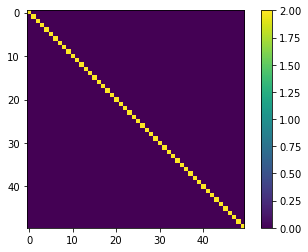

In [13]:
P = zeros([N,N]) + eye(N)*alpha**-1
imshow(P)
colorbar()
show()

In [14]:
# Make sure that, for training, the network is ready
restore('initialized')
P = zeros([N,N]) + eye(N)*alpha**-1
outsyn.plastic = True # allows wo to update
inneur.training = True

In [15]:
# Train the network
run(300*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.03s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


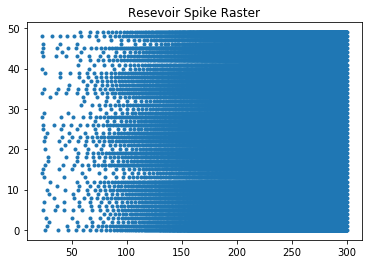

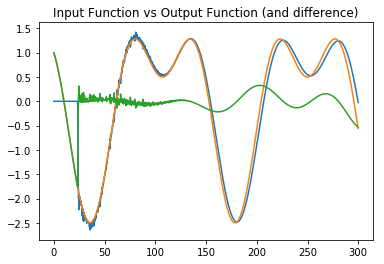

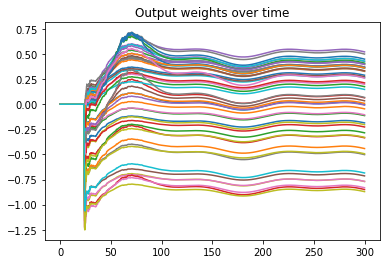

In [16]:
# Show some various plots

#for i in range(N):
#    plot(checkState.t/ms, checkState.Iext[i])
#show()
#plot(checkState.t/ms, checkState.V[0])
#show()
plot(resSpikeMon.t/ms, resSpikeMon.i,'.')
title('Resevoir Spike Raster')
show()

plot(outMon.t/ms, outMon.z.flatten())
plot(inMon.t/ms, inMon.F.flatten())
plot(inMon.t/ms, inMon.F.flatten() - outMon.z.flatten())
title('Input Function vs Output Function (and difference)')
show()

for i in range(N):
    plot(woMon.t/ms,woMon.wo[i])
title('Output weights over time')
show()

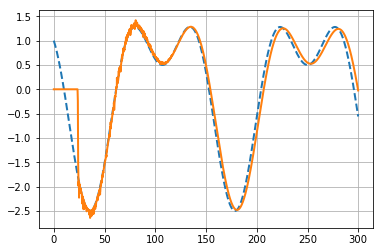

In [17]:
plot(inMon.t/ms, inMon.F.flatten(),ls='--',lw=2)
plot(outMon.t/ms, outMon.z.flatten(),lw=2)
#xlim([200,600]); ylim([-4,4])
grid()
show()

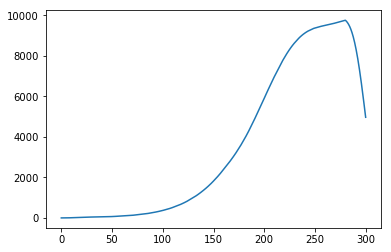

In [18]:
plot(resRateMon.t/ms, resRateMon.smooth_rate(width=10*ms)/Hz)

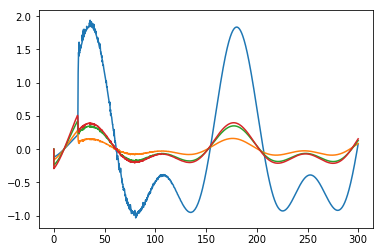

In [19]:
for i in range(4):
    plot(resMon.t/ms, resMon.Ifb[i] + resMon.Iext[i])
show()

In [20]:
store('after_training')

In [21]:
# Try turning off input and stopping output weight training, see what happens?
restore('after_training')

In [22]:
#insyn.wi = 0
outsyn.plastic = False
inneur.training = False
inneur.noiseAmp = 1
run(1000*ms)

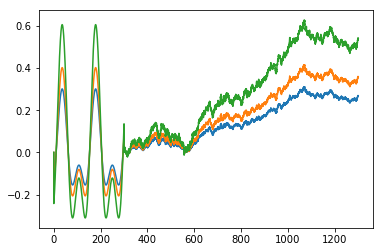

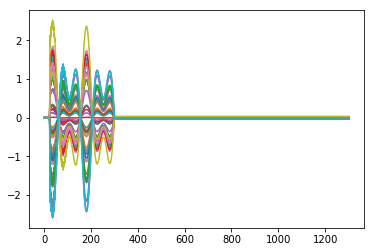

In [23]:
# Plot Iext (i.e. F times input weight)
for i in range(3):
    plot(resMon.t/ms, resMon.Iext[i])
show()
for i in range(N):
    plot(resMon.t/ms, resMon.Ifb[i])
show()

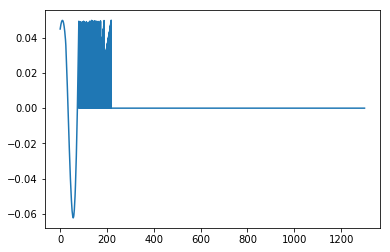

In [24]:
plot(resMon.t/ms, resMon.V[4])
show()

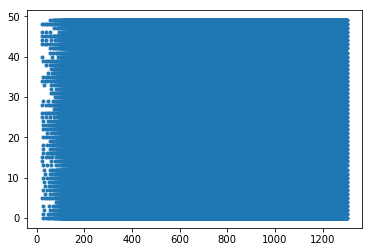

In [25]:
plot(resSpikeMon.t/ms, resSpikeMon.i,'.')
show()

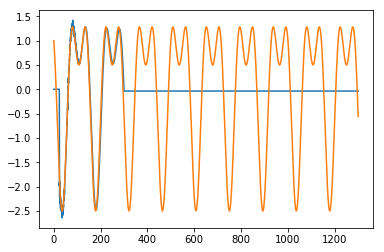

In [26]:
plot(outMon.t/ms, outMon.z.flatten())
plot(outMon.t/ms, cos(28 * pi * Hz * outMon.t) - 1.5 * sin(14 * pi * Hz * outMon.t))
show()

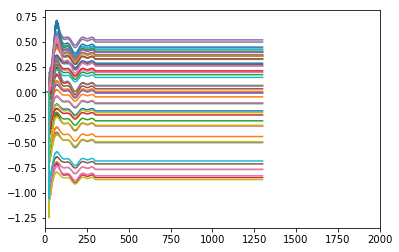

In [27]:
for i in range(N):
    plot(woMon.t/ms,woMon.wo[i])
xlim([0,2000])
show()

Once I turn off the driving input, it all breaks - I'm not sure why. Maybe there needs to be some white noise input to the system? Also the spike rate is INSANELY high for this, when it really shouldn't be. Maybe my time step is too small? Or the driving function is too big? Or the weights between the neurons are too large? I really have no idea.